Import

In [38]:
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import time

Load

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = Path('drive/My Drive/Colab Notebooks/tweepy/')

In [10]:
df = pd.read_csv(path/'tweets.csv')
df.head()

,created_at,tweet_id,tweet_text,screen_name,name,account_creation_date,urls,location,description
0,2020-10-10 05:41:16,1314803161400446977,@thesashaprofit Because he called for a screen...,TheNextBlGThing,Sasha Banks ̶S̶i̶t̶h̶ Simp Lord,Wed Jun 23 01:28:50 +0000 2010,[],LA,"Frank. 26. 🇵🇭. tweets about sasha banks, wrass..."
1,2020-10-10 05:41:15,1314803159374594050,RT @LakeShowYo: if Danny Green would’ve shot a...,lucaszapata__,lucas,Sat Sep 24 03:16:29 +0000 2016,[],"California, USA",married to @blurriess & @vicnipple is my banner 🥰
2,2020-10-10 05:41:15,1314803159034929152,RT @mldiffley: Nobody:\n\nDanny Green: https:/...,MrC_Reality,Yeng Badness,Thu Dec 15 15:18:12 +0000 2011,[],The Moon,NaN
3,2020-10-10 05:41:15,1314803158682603520,RT @seb_lco: Yo solo digo que Jordan no se la ...,Jesus13JE,Jesús A.Especier,Sun Apr 07 22:37:21 +0000 2013,[],Guarenas Edo Miranda Venezuela,Mi Dios Padre Primero. Nací en Los Llanos De A...
4,2020-10-10 05:41:15,1314803158644936704,Danny green hit the shot we not talkin bout shit,shocklitosway,Shockaveli,Sun May 09 23:11:35 +0000 2010,[],NaN,NaN


In [11]:
df.shape[0]

1000

In [52]:
df.screen_name.value_counts().head(10).reset_index().rename(columns={'index':'screen_name', 'screen_name':'frequency'})

,screen_name,frequency
0,DennisNderitu_,12
1,CholoG1119,4
2,rafertheprince,4
3,ShawnTapiru,3
4,row_atk,3
5,anonshiti,3
6,StillCush,3
7,zaddyass,3
8,Daif_23,3
9,GSWRevenge2021,3


Top accounts that have tweeted.

In [15]:
df.tweet_text.value_counts().head(10).reset_index()

,index,tweet_text
0,RT @7Dniggah: Danny Green: its okay we’ll get ...,27
1,"RT @BleacherReport: “I trusted him, we trusted...",25
2,RT @LakeShowYo: if Danny Green would’ve shot a...,25
3,RT @LakeShowYo: When I die I want DANNY GREEN ...,22
4,RT @LakeShowYo: i’m here in Orlando and just s...,18
5,RT @LonerMike_: The rim watchin Danny green sp...,17
6,RT @ramonashelburne: Danny Green missed his St...,15
7,RT @30SECVlDEOS: *Danny Green with a wide open...,15
8,RT @RamiahBalenYT: @BleacherReport Danny green...,13
9,RT @Jah2Solid: If Danny Green shot Tupac he’d ...,12


Top 10 retweeted tweets include 7Dniggah (Content Creator), Bleacher Report, Ramona Shelburne and LakeShowYo.

In [16]:
df['account_creation_date_month'] = (pd.to_datetime(pd.to_datetime(df.account_creation_date)
                                                     .apply(lambda x: x.strftime('%Y-%m'))))

In [18]:
accounts = df.copy()
accounts = accounts.drop_duplicates(['screen_name'], keep='first')

In [19]:
accounts.shape[0]

890

In [20]:
accounts.account_creation_date_month.value_counts().head(10)

2015-04-01    14
2011-01-01    13
2019-07-01    13
2014-12-01    12
2014-07-01    12
2012-06-01    12
2013-06-01    12
2020-08-01    12
2012-08-01    11
2011-08-01    11
Name: account_creation_date_month, dtype: int64

As old as 9 years old and as young as an account created two months ago.

In [39]:
# regex to strip hashtags.
import ast
import re
df['hashtags'] = df['tweet_text'].apply(lambda x: str(re.findall(r"#(\w+)", str(x))))

In [40]:
def hashtags(col):
    
    col = col.apply(lambda x: ast.literal_eval(x))
    
    def mapper(s):
        all_vals = list()

        for l in s:
            [all_vals.append(x.lower()) for x in l]

        all_vals.sort()
        return all_vals

    def reducer(l):
        all_counts = dict()
        prev = l[0]
        count = 0

        for x in l:
            if x == prev:
                count = count + 1
            else:
                all_counts[prev] = count
                prev = x
                count = 1      

        all_counts[prev] = count

        return all_counts
    
    mapped = mapper(col)
    reduced = reducer(mapped)
    reduced = dict(sorted(reduced.items(), key=lambda x: x[1], reverse=True))
    
    df = pd.DataFrame(list(reduced.items()), columns=['hashtag', 'number']).head(20).sort_values('number', ascending=True)
    return df

In [48]:
def bar_chart(tags, number, title):
    plt.figure(figsize=(10,5))
    plt.barh(tags, number)
    plt.title(title)
    plt.xlabel('Number of times, the hashtag appeared')
    plt.show();

In [49]:
new = df[df.hashtags.map(lambda x: len(x) >= 1)]
tags = hashtags(new.hashtags)

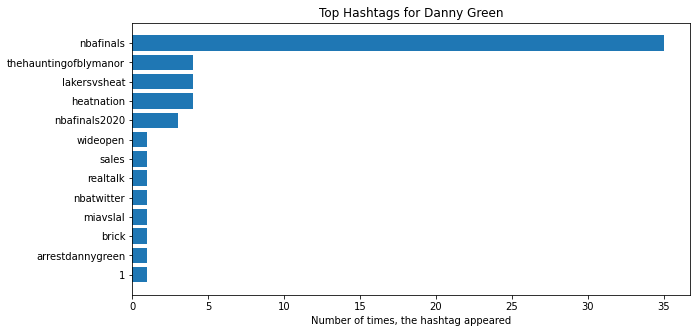

In [51]:
bar_chart(tags.hashtag, tags.number, 'Top Hashtags for Danny Green')

Wasn't that bad. Still related to the NBA Finals except for the show - The Haunting of Bly Manor (Netflix).

In [53]:
df['urls'] = df.urls.apply(lambda x: ast.literal_eval(x))

In [54]:
df = df[df.urls.map(lambda x: len(x) >= 1)]

In [55]:
def unpack(row):
    array = []
    for i in row['urls']:
        array.append(i['expanded_url'])
    return array

"""create a new column using your function which contains the extracted url or urls"""
df['expanded_urls'] = df.apply(unpack, axis=1)

"""function that takes the list of urls in each row, aggregates them, and then returns the top 10 links from your dataset"""
def urls(col):
    
    def mapper(s):
        all_vals = list()

        for l in s:
            [all_vals.append(x) for x in l]

        all_vals.sort()
        return all_vals

    def reducer(l):
        all_counts = dict()
        prev = l[0]
        count = 0

        for x in l:
            if x == prev:
                count = count + 1
            else:
                all_counts[prev] = count
                prev = x
                count = 1      

        all_counts[prev] = count

        return all_counts
    
    mapped = mapper(col)
    reduced = reducer(mapped)
    reduced = dict(sorted(reduced.items(), key=lambda x: x[1], reverse=True))
    
    df = pd.DataFrame(list(reduced.items()), columns=['url', 'number']).head(10).sort_values('number', ascending=False)
    return df
    
"""use the function on the column that houses your extracted_urls to get the top 10 urls"""
urls(df.expanded_urls)

,url,number
0,https://amzn.to/2Fk9TY8,8
1,https://fadeawayworld.net/2020/10/10/lakers-fa...,2
2,https://www.change.org/p/the-los-angeles-laker...,2
3,http://cmplx.co/yqWjUIc,1
4,https://twitter.com/BleacherReport/status/1314...,1
5,https://twitter.com/LaJethroJenkins/status/131...,1
6,https://twitter.com/NBAdabad/status/1314773466...,1
7,https://twitter.com/OlivingstonTV/status/13147...,1
8,https://twitter.com/barstoolsports/status/1314...,1
9,https://twitter.com/barterr7/status/1314788506...,1


Remarks:

* In terms of what URLs are connected to the tweets, got to love the rubbermaid trash can amazon ad as the top URL being linked. This is probably to imply  Danny Green's performance tonight. 

* Fadeawayworld.net has an article that talks about Laker fans all over that are "pissed" at Danny Green missing the clutch three pointer.

* There's also a change.org petition for him to be off the squad.